# Data processing in Python - Final Project
# "Spatial Autocorrelation in Regional Covid Incidence 2020-2021"
### Heriberto Castilla, Jan Provazník

### DATA INTERPRETER
Our project does this 

## Import libraries and packages

In [1]:
import pandas as pd

## Define class

In [2]:
class Country:

    def __init__(self, name, df):
        self.name = name
        self.df = df

    def plot(self):
        self.df.plot()

## 1 Load data

In [26]:
# Load the weekly data
url ="https://opendata.ecdc.europa.eu/covid19/subnationalcaseweekly/csv"
weekly = pd.read_csv(url, sep=',')

# Load the daily data from downloaded file
daily = pd.read_csv("covid_daily_data.csv", sep=',')

In [27]:
weekly.head()
weekly['country'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

In [5]:
daily.head()
daily['country'].unique()

array(['Austria', 'Denmark', 'Finland', 'Germany', 'Italy', 'Netherlands',
       'Portugal', 'Slovakia', 'Sweden', 'Belgium'], dtype=object)

## 2 Visualize data

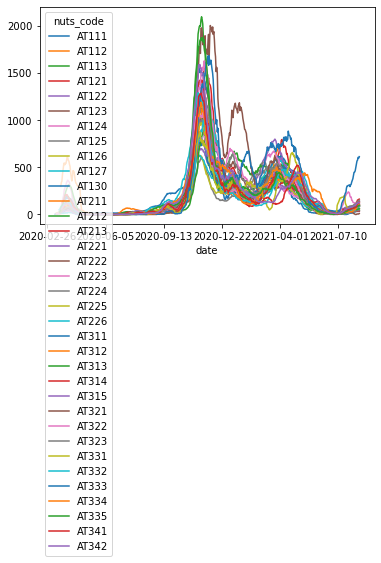

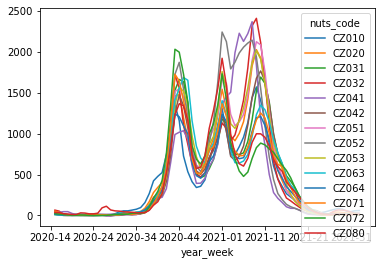

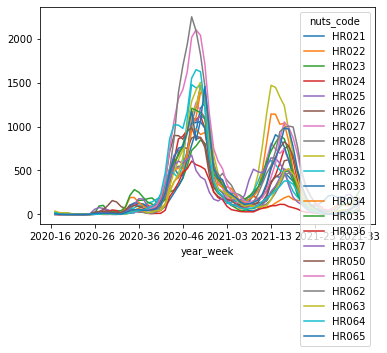

In [28]:
# Slice data from Austrian regions as an example
daily_au = daily.loc[daily['country'] == 'Austria']
daily_au = daily_au.pivot(index='date', columns='nuts_code', values='rate_14_day_per_100k')
daily_au.plot()

# Slice data from Czech regions as an example
weekly_cz = weekly.loc[weekly['country'] == 'Czechia']
weekly_cz = weekly_cz.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
weekly_cz.plot()

# Define a function that inputs a dataframe, country name and index then returns only the country's dataframe
def get_country_df(df, country, index):
    df_country= df.loc[df['country'] == country]
    df_country = df_country.pivot(index=index, columns='nuts_code', values='rate_14_day_per_100k')
    return df_country

# Create dictionary that maps from country name to Country() object
countries = {}

# Store all countries in weekly dataset with their own dataframe separately
for country in weekly['country'].unique():
    df = get_country_df(weekly, country, index='year_week')
    country_obj = Country(country, df)
    countries[country] = country_obj

# As an example, plot Croatia's covid cases, with a line for each region
countries['Croatia'].plot()

In [7]:
# Pivot data so that index = nuts_code and columns = cases per year_week
nuts_code_index = weekly.pivot(index='nuts_code', columns='year_week', values='rate_14_day_per_100k')
nuts_code_index.head()

year_week,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,2020-20,2020-21,2020-22,...,2021-24,2021-25,2021-26,2021-27,2021-28,2021-29,2021-30,2021-31,2021-32,2021-33
nuts_code,,,,,,,,,,,,,,,,,,,,,
AT11,NaN,57.397873,31.925444,23.774267,15.962722,8.490810,4.075589,2.037794,2.717059,2.037794,...,22.415737,22.755370,20.377943,17.321251,16.302354,20.377943,33.283973,37.359562,54.001549,90.342214
AT12,NaN,85.496118,53.316329,30.873598,11.815089,7.599655,6.234092,6.709070,6.530953,4.452923,...,27.014398,16.446128,13.061907,14.308725,23.986411,32.417278,43.698016,56.641178,79.974494,119.575821
AT13,NaN,66.189094,46.358527,26.161697,18.103894,17.109750,16.534193,20.144507,21.034004,16.534193,...,53.474509,40.655277,33.905559,42.329626,61.218371,73.252752,85.130162,98.472628,134.261829,208.770343
AT21,NaN,40.264176,23.873449,11.402244,1.781601,0.890800,0.178160,0.356320,0.356320,0.712640,...,21.379208,8.908003,2.850561,7.660883,22.982649,40.798656,59.149143,67.522666,83.022592,106.183402
AT22,NaN,69.079224,49.663229,27.760060,15.003269,9.226610,5.937123,3.851107,1.684859,1.123239,...,15.003269,7.060362,5.535966,10.911469,31.129778,40.918008,50.465543,63.142102,83.601106,128.851608


## 3 Load shapefile

In [13]:
import geopandas as gpd
import gdal
import shapely
import matplotlib.pyplot as plt
import descartes

shapefile = gpd.read_file('NUTS3')

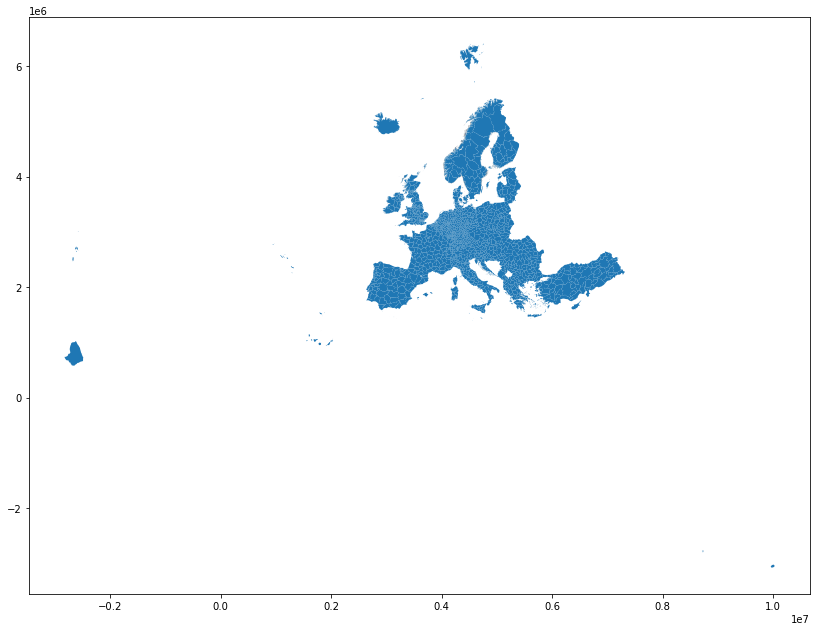

In [12]:
shapefile.plot(figsize=(14, 15))
plt.show()

In [14]:
print(shapefile.head())

  NUTS_ID  LEVL_CODE CNTR_CODE                    NAME_LATN  \
0   NO0B2          3        NO                     Svalbard   
1   NO0B1          3        NO         Jan Mayen\r\n   \r\n   
2   HR064          3        HR  Krapinsko-zagorska županija   
3   DE21A          3        DE                       Erding   
4   DE94E          3        DE         Osnabrück, Landkreis   

                     NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0                     Svalbard         3.0        3.0           1  NO0B2   
1         Jan Mayen\r\n   \r\n         NaN        NaN           1  NO0B1   
2  Krapinsko-zagorska županija         4.0        3.0           3  HR064   
3                       Erding         4.0        3.0           3  DE21A   
4         Osnabrück, Landkreis         4.0        2.0           3  DE94E   

                                            geometry  
0  MULTIPOLYGON (((4760536.161 6404487.632, 47607...  
1  POLYGON ((3673081.665 5420781.907, 3673257.365...  

In [15]:
shapefile["CNTR_CODE"].unique()

array(['NO', 'HR', 'DE', 'AL', 'BE', 'AT', 'ES', 'BG', 'FR', 'CZ', 'HU',
       'EL', 'FI', 'CH', 'CY', 'DK', 'EE', 'NL', 'IS', 'LV', 'MK', 'MT',
       'LT', 'IT', 'RS', 'PT', 'ME', 'PL', 'SE', 'IE', 'LU', 'RO', 'TR',
       'UK', 'LI', 'SK', 'SI'], dtype=object)

In [18]:
nuty_v_datech = [i for i in daily['nuts_code'].unique()]

In [19]:
vyber = [i for i in shapefile['NUTS_ID'].unique() if i in nuty_v_datech]

In [20]:
len(vyber)

622

In [45]:
daily.head()

,country,region_name,nuts_code,date,rate_14_day_per_100k,source
0,Austria,Mittelburgenland,AT111,2020-03-18,NaN,"TESSy COVID-19, subnational daily data"
1,Austria,Mittelburgenland,AT111,2020-03-19,NaN,"TESSy COVID-19, subnational daily data"
2,Austria,Mittelburgenland,AT111,2020-03-20,NaN,"TESSy COVID-19, subnational daily data"
3,Austria,Mittelburgenland,AT111,2020-03-21,NaN,"TESSy COVID-19, subnational daily data"
4,Austria,Mittelburgenland,AT111,2020-03-22,NaN,"TESSy COVID-19, subnational daily data"


In [70]:
daily['nuts_code'].unique()

array(['AT111', 'AT112', 'AT113', 'AT121', 'AT122', 'AT123', 'AT124',
       'AT125', 'AT126', 'AT127', 'AT130', 'AT211', 'AT212', 'AT213',
       'AT221', 'AT222', 'AT223', 'AT224', 'AT225', 'AT226', 'AT311',
       'AT312', 'AT313', 'AT314', 'AT315', 'AT321', 'AT322', 'AT323',
       'AT331', 'AT332', 'AT333', 'AT334', 'AT335', 'AT341', 'AT342',
       'DK011', 'DK012', 'DK013', 'DK014', 'DK021', 'DK022', 'DK031',
       'DK032', 'DK041', 'DK042', 'DK050', 'FI193', 'FI194', 'FI195',
       'FI196', 'FI197', 'FI1B1', 'FI1C1', 'FI1C2', 'FI1C3', 'FI1C4',
       'FI1C5', 'FI1D1', 'FI1D2', 'FI1D3', 'FI1D5', 'FI1D7', 'FI1D8',
       'FI1D9', 'FI200', 'DE111', 'DE112', 'DE113', 'DE114', 'DE115',
       'DE116', 'DE117', 'DE118', 'DE119', 'DE11A', 'DE11B', 'DE11C',
       'DE11D', 'DE121', 'DE122', 'DE123', 'DE124', 'DE125', 'DE126',
       'DE127', 'DE128', 'DE129', 'DE12A', 'DE12B', 'DE12C', 'DE131',
       'DE132', 'DE133', 'DE134', 'DE135', 'DE136', 'DE137', 'DE138',
       'DE139', 'DE1

In [33]:
shapefile['NUTS_ID'].unique()

array(['NO0B2', 'NO0B1', 'HR064', ..., 'UKM76', 'UKM78', 'UKK24'],
      dtype=object)

In [31]:
codes = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'LV', 'LI', 'LT', 'LU', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE']

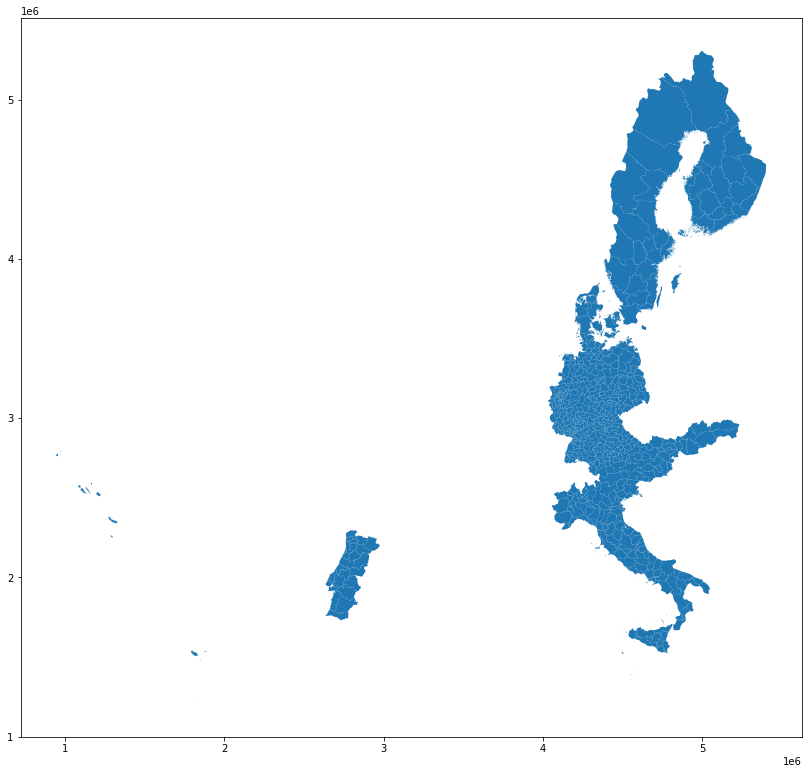

In [36]:
vyber = shapefile[shapefile['FID'].isin(daily['nuts_code'].unique())]
vyber.plot(figsize=(14, 15))
plt.show()

### Visualize one country in the shapefile

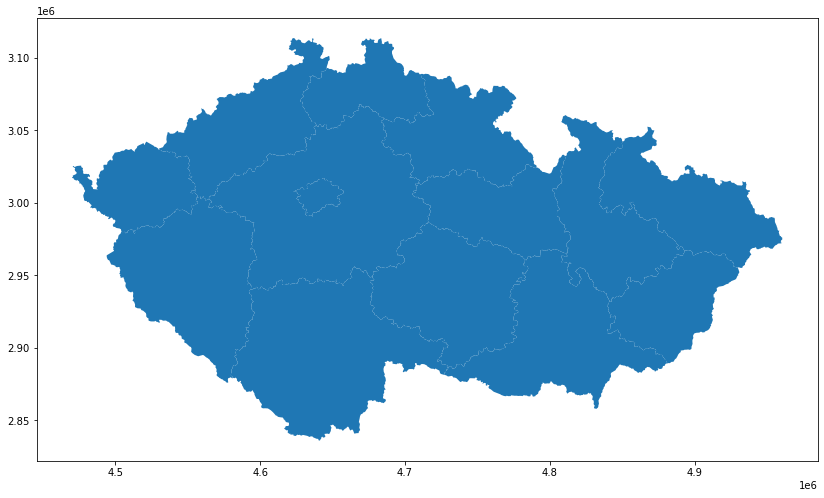

In [41]:
country_shapefile = shapefile.loc[shapefile['CNTR_CODE'] == 'CZ']
country_shapefile.head()
country_shapefile.plot(figsize=(14, 15))
plt.show()

In [62]:
country_data = nuts_code_index[nuts_code_index.index.str.startswith('CZ')]
country_data.head()

year_week,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,2020-20,2020-21,2020-22,...,2021-24,2021-25,2021-26,2021-27,2021-28,2021-29,2021-30,2021-31,2021-32,2021-33
nuts_code,,,,,,,,,,,,,,,,,,,,,
CZ010,NaN,NaN,53.916212,37.378887,15.782197,9.590139,10.949371,15.329119,15.706684,12.988219,...,33.376703,43.419919,57.993909,72.718925,84.196886,78.382393,54.671341,46.666974,57.691858,60.334809
CZ020,NaN,NaN,29.311095,19.853574,8.302404,6.208754,4.909248,7.508261,7.147287,3.104377,...,18.193094,17.976509,21.730640,34.509122,42.522747,36.097408,31.188161,27.650615,27.361835,31.043771
CZ031,NaN,NaN,10.868165,6.831418,2.639411,1.552595,0.931557,0.931557,0.310519,0.931557,...,36.485981,15.370690,8.228753,10.712905,13.818095,14.439133,16.302247,22.357367,28.101968,34.467607
CZ032,NaN,NaN,65.434930,53.059931,16.273972,8.645548,5.763699,6.441781,4.746575,1.525685,...,26.275684,12.205479,20.851027,49.839040,67.808218,66.282533,58.823629,42.041095,25.428082,18.986301
CZ041,NaN,NaN,40.724350,39.366872,46.833003,46.833003,25.113349,9.502348,7.805501,5.769283,...,6.108653,3.393696,5.769283,10.181088,10.181088,14.253523,11.199196,7.126761,19.344066,25.113349


In [65]:
merged = country_shapefile.set_index('NUTS_ID').join(country_data)
merged.head()

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,2020-13,...,2021-24,2021-25,2021-26,2021-27,2021-28,2021-29,2021-30,2021-31,2021-32,2021-33
NUTS_ID,,,,,,,,,,,,,,,,,,,,,
CZ031,3,CZ,Jihočeský kraj,Jihočeský kraj,4.0,3.0,3,CZ031,"POLYGON ((4677657.887 2949338.392, 4677470.601...",NaN,...,36.485981,15.370690,8.228753,10.712905,13.818095,14.439133,16.302247,22.357367,28.101968,34.467607
CZ071,3,CZ,Olomoucký kraj,Olomoucký kraj,2.0,2.0,3,CZ071,"POLYGON ((4810829.482 3060614.489, 4812123.234...",NaN,...,14.240168,5.696067,3.797378,8.702325,13.132600,10.759238,7.436532,17.879322,20.885580,12.025031
CZ032,3,CZ,Plzeňský kraj,Plzeňský kraj,4.0,3.0,3,CZ032,"POLYGON ((4564741.060 3003138.054, 4564863.351...",NaN,...,26.275684,12.205479,20.851027,49.839040,67.808218,66.282533,58.823629,42.041095,25.428082,18.986301
CZ064,3,CZ,Jihomoravský kraj,Jihomoravský kraj,4.0,2.0,3,CZ064,"POLYGON ((4812156.935 2965655.696, 4812077.044...",NaN,...,15.184704,19.127693,18.456546,12.248435,14.765237,16.275318,15.100810,16.778678,20.218307,19.631054
CZ063,3,CZ,Kraj Vysočina,Kraj Vysočina,4.0,3.0,3,CZ063,"POLYGON ((4782782.205 2960974.984, 4782673.811...",NaN,...,20.595787,7.846014,4.119157,18.241983,21.968840,12.945923,15.103577,22.164990,24.714944,19.418885


In [70]:
week = '2021-24'
merged.sort_values(by=week, ascending=False)

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,2020-13,...,2021-24,2021-25,2021-26,2021-27,2021-28,2021-29,2021-30,2021-31,2021-32,2021-33
NUTS_ID,,,,,,,,,,,,,,,,,,,,,
CZ031,3,CZ,Jihočeský kraj,Jihočeský kraj,4.0,3.0,3,CZ031,"POLYGON ((4677657.887 2949338.392, 4677470.601...",NaN,...,36.485981,15.370690,8.228753,10.712905,13.818095,14.439133,16.302247,22.357367,28.101968,34.467607
CZ010,3,CZ,Hlavní město Praha,Hlavní město Praha,4.0,1.0,3,CZ010,"POLYGON ((4643020.233 3016786.996, 4644155.939...",NaN,...,33.376703,43.419919,57.993909,72.718925,84.196886,78.382393,54.671341,46.666974,57.691858,60.334809
CZ051,3,CZ,Liberecký kraj,Liberecký kraj,3.0,2.0,3,CZ051,"POLYGON ((4710986.851 3088955.848, 4710985.617...",NaN,...,32.455093,19.157520,17.129077,16.002164,16.452929,19.157520,21.411346,19.382902,22.538259,31.328180
CZ032,3,CZ,Plzeňský kraj,Plzeňský kraj,4.0,3.0,3,CZ032,"POLYGON ((4564741.060 3003138.054, 4564863.351...",NaN,...,26.275684,12.205479,20.851027,49.839040,67.808218,66.282533,58.823629,42.041095,25.428082,18.986301
CZ072,3,CZ,Zlínský kraj,Zlínský kraj,2.0,2.0,3,CZ072,"POLYGON ((4929608.184 2955255.716, 4930039.955...",NaN,...,21.972174,16.307473,14.075924,10.127799,12.187690,12.874321,10.127799,9.612826,9.956141,9.612826
CZ080,3,CZ,Moravskoslezský kraj,Moravskoslezský kraj,4.0,2.0,3,CZ080,"POLYGON ((4895030.487 3026304.289, 4896182.204...",NaN,...,21.656939,15.243153,13.410643,16.326000,16.242704,15.076561,11.661429,9.579031,12.827572,14.660082
CZ063,3,CZ,Kraj Vysočina,Kraj Vysočina,4.0,3.0,3,CZ063,"POLYGON ((4782782.205 2960974.984, 4782673.811...",NaN,...,20.595787,7.846014,4.119157,18.241983,21.968840,12.945923,15.103577,22.164990,24.714944,19.418885
CZ020,3,CZ,Středočeský kraj,Středočeský kraj,4.0,1.0,3,CZ020,"MULTIPOLYGON (((4685657.699 3058491.541, 46853...",NaN,...,18.193094,17.976509,21.730640,34.509122,42.522747,36.097408,31.188161,27.650615,27.361835,31.043771
CZ064,3,CZ,Jihomoravský kraj,Jihomoravský kraj,4.0,2.0,3,CZ064,"POLYGON ((4812156.935 2965655.696, 4812077.044...",NaN,...,15.184704,19.127693,18.456546,12.248435,14.765237,16.275318,15.100810,16.778678,20.218307,19.631054


<AxesSubplot:>

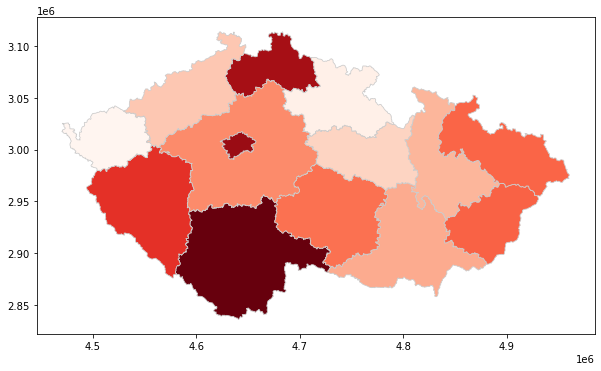

In [72]:
# set the range for the color map
vmin, vmax = 120, 220
# create figure and axes for plot
fig, ax = plt.subplots(1, figsize=(10, 6))

merged.plot(column=week, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')


## 4 Generate weight matrix

## 5 Calculate Moran's I from the data and the matrix

## 6 Visualize Moran's I time series

Here we will visualize the Moran's I time series in a plot. We don't have the series yet, so let's generate a random one for now and visualize it and then at the end, when the series is finally obtained, we will just substitute it in the plot.

In [11]:
import numpy as np
import pandas as pd

# Generate a random time series y
y = [0]*400
for i in range(1,400):
    y[i] = 0.5*y[i-1] + np.random.normal(loc=0.0, scale=1.0, size=None)
y = pd.DataFrame(y)

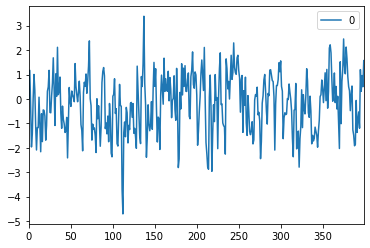

In [14]:
#make a plot of y:
y.plot()